# Importing Libraries and Data

In [ ]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import random
import numpy as np
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)
import os
import re
import warnings
torch.use_deterministic_algorithms(False)
import pandas as pd
from gensim.models import KeyedVectors
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = "/content/drive/MyDrive/Fellowship.AI/IMDB Dataset.csv"

In [ ]:
df = pd.read_csv(filename)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# New section

In [ ]:
df["binary_sentiment"] = np.where(df['sentiment'] == 'positive',1,0)
df.head(10)

,review,sentiment,binary_sentiment
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
5,"Probably my all-time favorite movie, a story o...",positive,1
6,I sure would like to see a resurrection of a u...,positive,1
7,"This show was an amazing, fresh & innovative i...",negative,0
8,Encouraged by the positive comments about this...,negative,0
9,If you like original gut wrenching laughter yo...,positive,1


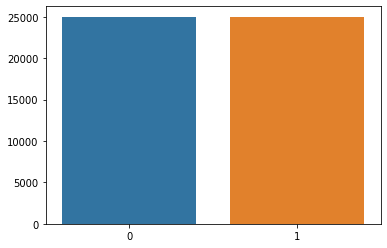

In [ ]:
overall_frequency_count = df.binary_sentiment.value_counts()
sns.barplot(x=overall_frequency_count.index, y=overall_frequency_count.values)

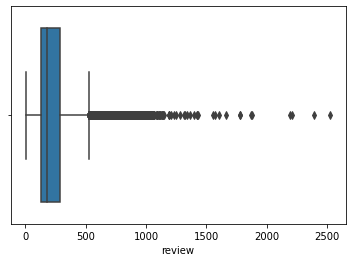

In [ ]:
re_wordMatcher = re.compile(r'[a-z0-9]+') #Declare regex to extract words
numWords = df["review"].map(lambda x: len(re_wordMatcher.findall(x.lower())))
g = sns.boxplot(numWords)

In [ ]:
train_df = df[:35000]
test_df = df[35000:]

In [ ]:
!pip install wget
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
word2VecFile = os.path.join(os.curdir, 'wiki.multi.en.vec')

if os.path.exists(word2VecFile):
    print('Word2Vec file has been found and is being loaded...')
else:    
    print('Word2Vec file does not exist and needs to be downloaded')
    url = 'https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec'
    wget.download(url)
    print('Downloading from', url)
en_model = KeyedVectors.load_word2vec_format('wiki.multi.en.vec')

Word2Vec file has been found and is being loaded...


In [ ]:
embeddingDim = 300   

In [ ]:
vocab = list(en_model.vocab.keys())
print("Vocab size in pretrained model:", len(vocab))

# check if the word 'and' is present in the pretrained model
assert "and" in en_model

# check the dimension of the word vectors
assert embeddingDim == len(en_model["and"])

# initialize a numpy matrix which will store the word vectors
# first row is for the padding token
pretrained_weights = np.zeros((1+len(vocab), embeddingDim))

# tqdm just adds a progress bar
for i, token in enumerate(vocab):
    pretrained_weights[i, :] = en_model[token]

# map tokens in the vocab to ids
vocab = dict(zip(vocab, range(1, len(vocab)+1)))

Vocab size in pretrained model: 200000


In [ ]:
def reviewText2Features(reviewText):
    """
    Function which takes review text (basically a string!) as input and returns a features matrix X of shape
    (maxlen, embeddingDim). This is done by splitting the review into words and then representing each word by it's
    word vector obtained from the Word2Vec model. Sentences having more than maxlen words are truncated while shorter
    ones are zero-padded by pre-adding all zero vectors.
    """
    X = []
    
    reviewWords = re_wordMatcher.findall(reviewText.lower())
    
    """
    Tokenize the review using the word-matching regex and get its word vector from the pretrained Word2Vec model.
    Words not found in the Word2Vec model are ignored
    """
    for i, word in enumerate(reviewWords):
        if word not in en_model:
            continue
        if i >= maxlen:
            break
        # X.append(en_model[word])
        X.append(vocab[word])
    
    """
    Add zero padding in the begining of the sequence if the number of words is less than maxlen.
    """
    if len(X) < maxlen:
        # zero_padding = [[0.]*embeddingDim]*(maxlen - len(X))
        zero_padding = [0.]*(maxlen - len(X))
        X = zero_padding + X
    
    return X # np.array(X)
        
def row2Features(row):
    """
    Function which takes a datafram row as input and produces features and labels.
    
    Input: row | Type: pandas.core.series.Series
    
    Output: X, y | Type: X - np.ndarray of shape (maxlen, embeddingDim) & y - int where Positive = 0 & Negative = 1
    """    
    
    X = reviewText2Features(row["review"])
    y = 1. if row["sentiment"] == "negative" else 0.
        
    return X, y

In [ ]:
sampleRow = df.iloc[0]
reviewWords = re_wordMatcher.findall(sampleRow["review"].lower())
print("Review:", sampleRow["review"])
print("Rating:", sampleRow["binary_sentiment"])
print("Sentiment:", sampleRow["sentiment"])
print("Review words:", reviewWords)

Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

In [ ]:
maxlen = 258

In [ ]:
X, y = row2Features(sampleRow)
print("Dimension of X:", len(X))
print("Label y:", y)

Dimension of X: 258
Label y: 0.0


In [ ]:
def shuffleArray(X, y):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx, :]
    y = y[idx]
    return X, y

def generateModelReadyData(data, batchSize = 128, shuffle=False):
    """
    Generator function which generates features and labels in batches
    
    Input:b
    data - DataFrame where each row has review and sentiment
    batchSize - No. of rows for which features will be created and returned in a batch.
    Note: This is useful for running mini-batch Gradient Descent optimization when the dataset is large.
    
    Output:
    X - 3D np.ndarray of shape (batchSize, maxlen, embeddingDim)
    y - 1D np. array of shape (batchSize,)        
    """
    
    while(True):
        X = []
        y = []
        for _, row in data.iterrows():
            """Generate features and label for this row"""
            X_, y_ = row2Features(row)

            """Keep accumulating the row-wise features"""
            X.append(X_)
            y.append(y_)   

            """If number of rows processed is greater than batchSize yield the batch and trim down X & y
            Note: This way we avoid running into memory issues by not bloating X and y bigger and bigger
            """
            if len(X) > batchSize:
                temp_X, temp_y = np.array(X[:batchSize]), np.array(y[:batchSize])
                if shuffle:
                    temp_X, temp_y = shuffleArray(temp_X, temp_y)
                
                X, y = X[batchSize:], y[batchSize:]                    
                yield temp_X, temp_y

        """Yield the remaining few rows when number of rows in data isn't a mutiple of batchSize"""
        if len(X) > 0:
            temp_X, temp_y = np.array(X), np.array(y)
            if shuffle:
                temp_X, temp_y = shuffleArray(temp_X, temp_y)
            
            yield temp_X, temp_y

In [ ]:
numBatches = 0
for i, (X, y) in enumerate(generateModelReadyData(df, batchSize=128, shuffle=True)):
    if numBatches >= 3:
        break
    
    else:
        print("Batch:", i)
        assert X.shape == (128, maxlen)
        assert y.shape == (128,)
        print("Shape of X & y matches expected values")
    numBatches += 1

Batch: 0
Shape of X & y matches expected values
Batch: 1
Shape of X & y matches expected values
Batch: 2
Shape of X & y matches expected values


In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    print("cuda available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda available


In [ ]:
class SentimentNet(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, pretrained_weights):
        super(SentimentNet, self).__init__()
        
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
        
        """
        Adding a dropout layer to force some of the feature values to zero.
        Note: Dropout is a regularization technique which sets the activation of few randomly chosen neurons of
        a hidden layer to zero. It can also be applied to the input layer where some of the input features are set to zero.
        """
        #print(embedding_dim, hidden_dim, vocab_size, pretrained_weights)
        self.sentInputDropout = nn.Dropout(0.1)
        
        """
        Now let's stack a couple of bidirectional RNNs to process the input sequence and extract features
        """
        self.biLSTM1 = nn.LSTM(embedding_dim, hidden_dim[0], bidirectional=True, batch_first=True)
        self.biLSTMDropOut = nn.Dropout(0.1)
        # self.biLSTM2 = nn.LSTM(2*hidden_dim[0], hidden_dim[1], bidirectional=True, batch_first=True)
        
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.Linear(2*hidden_dim[0], 50)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        
        self.outputLayer = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.hidden_dim = hidden_dim
        
    def forward(self, x):
        
        batch_len = x.shape[0]
        out = self.embedding(x)
        out = self.sentInputDropout(out)
        out, hidden = self.biLSTM1(out)
        out = self.biLSTMDropOut(out)
        # out, hidden = self.biLSTM2(out)
        
        out = self.dropout1(out)
        out = self.dense1(out)
        out = self.relu1(out)
        out = self.dropout2(out)
        
        out = self.outputLayer(out)
        out = self.sigmoid(out)
        out = out.view(batch_len, -1)
        out = out[:,-1]
        return out  

In [ ]:
model = SentimentNet(embeddingDim, [100, 50], 1+len(vocab), pretrained_weights)
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.1, inplace=False)
  (biLSTM1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.1, inplace=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=200, out_features=50, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (outputLayer): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 5
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model = model.float()
model.train()
for i in range(epochs):
    print("Epoch:", i+1)
    #h = model.init_hidden(128)
    print("Running a pass over the training data...")
    for j, (inputs, labels) in enumerate(generateModelReadyData(train_df, batchSize=128, shuffle=True)):
        if j >= np.ceil(train_df.shape[0]/128):
            break
        
    #for inputs, labels in train_loader:
        counter += 1
        #h = tuple([e.data for e in h])
        inputs, labels = torch.from_numpy(inputs), torch.from_numpy(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        #output, h = model(inputs, h)
        output = model(inputs.long())
        #print(output.shape)
        #print(output)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        if (j+1) % 100 == 0:
            print("Batches completed:", j+1)
    
    print("Batches completed:", j+1)

    #val_h = model.init_hidden(batch_size)
    val_losses = []
    model.eval()
    print("Running a pass over the test data...")
    for k, (inp, lab) in enumerate(generateModelReadyData(test_df, batchSize=128, shuffle=False)):
        if k >= np.ceil(test_df.shape[0]/128):
            break
    #for inp, lab in val_loader:
        #val_h = tuple([each.data for each in val_h])
        inp, lab = torch.from_numpy(inp), torch.from_numpy(lab)
        inp, lab = inp.to(device), lab.to(device)
        out = model(inp.long())
        val_loss = criterion(out.squeeze(), lab.float())
        val_losses.append(val_loss.item())
        if (k+1) % 100 == 0:
            print("Batches completed:", k+1)
    
    print("Batches completed:", k+1)

    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch: 1
Running a pass over the training data...
Batches completed: 100
Batches completed: 200
Batches completed: 275
Running a pass over the test data...
Batches completed: 100
Batches completed: 119
Epoch: 1/5... Step: 274... Loss: 0.358391... Val Loss: 0.381236
Validation loss decreased (inf --> 0.381236).  Saving model ...
Epoch: 2
Running a pass over the training data...
Batches completed: 100
Batches completed: 200
Batches completed: 275
Running a pass over the test data...
Batches completed: 100
Batches completed: 119
Epoch: 2/5... Step: 548... Loss: 0.168191... Val Loss: 0.347711
Validation loss decreased (0.381236 --> 0.347711).  Saving model ...
Epoch: 3
Running a pass over the training data...
Batches completed: 100
Batches completed: 200
Batches completed: 275
Running a pass over the test data...
Batches completed: 100
Batches completed: 119
Epoch: 3/5... Step: 822... Loss: 0.029934... Val Loss: 0.459014
Epoch: 4
Running a pass over the training data...
Batches completed: 

In [ ]:
freqCounts = train_df["binary_sentiment"].value_counts()
# weightOfPositive = round( (1./freqCounts["positive"]) / (1./freqCounts["positive"] + 1./freqCounts["negative"]), 3)
# weightOfNegative = round( (1./freqCounts["negative"]) / (1./freqCounts["positive"] + 1./freqCounts["negative"]), 3)
# print("Class weights:", weightOfPositive, weightOfNegative)
freqCounts

0    17510
1    17490
Name: binary_sentiment, dtype: int64

In [ ]:
model.load_state_dict(torch.load('./state_dict.pt'))
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.1, inplace=False)
  (biLSTM1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.1, inplace=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=200, out_features=50, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (outputLayer): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
test_losses = []
num_correct = 0
pred_proba = []
actual = []

model.eval()
for j, (X_test, y_test) in enumerate(generateModelReadyData(test_df, batchSize=128)):
    if j >= np.ceil(test_df.shape[0]/128):
        break
    
    inputs_test, labels_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    output_test = model(inputs_test.long())
    test_loss = criterion(output_test.squeeze(), labels_test.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output_test.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels_test.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    pred_proba.extend(output_test.cpu().squeeze().detach().numpy())
    actual.extend(y_test)
    
    if (j+1) % 100 == 0:
        print("Batches completed:", j+1)

print("Batches completed:", j+1)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_df)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Batches completed: 100
Batches completed: 119
Test loss: 0.348
Test accuracy: 86.553%


In [ ]:
print("Area under ROC:", roc_auc_score(actual, pred_proba))

Area under ROC: 0.9369924568754789


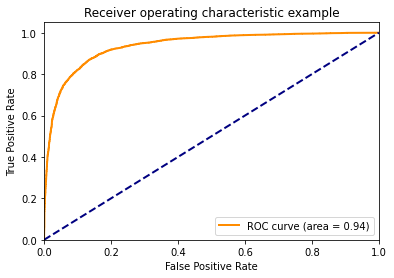

In [ ]:
fpr, tpr, thresholds = roc_curve(actual, pred_proba) 
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
predicted = pd.Series(["negative" if p>=0.5 else "positive" for p in pred_proba], name="Predicted")
actual = pd.Series(test_df["sentiment"], name="Actual")
confusion_matrix = pd.crosstab(actual, predicted)

In [ ]:
# ax= plt.subplot()
# g = sns.heatmap(confusion_matrix.values, annot=True, ax = ax, fmt="d", cmap="YlGnBu")
# g.set_xlabel('Predicted')
# g.set_ylabel('Actual')
# g.set_title('Confusion Matrix')
# g.xaxis.set_ticklabels(['Negative', 'Positive'])
# g.yaxis.set_ticklabels(['Negative', 'Positive'])
# plt.show()

In [ ]:
def predictSentiment(reviewText):
    X = reviewText2Features(reviewText)
    X = np.array(X).reshape((1, -1))
    X = torch.from_numpy(X)
    X = X.to(device)
    model.eval()
    pred_proba = model(X.long())
    pred_proba = pred_proba.cpu().squeeze().detach().numpy()
    if pred_proba >= 0.5:
        return "Negative", pred_proba
    else:
        return "Positive", pred_proba

In [ ]:

pos_reviews = list(test_df["review"].loc[test_df["sentiment"] == "positive"].iloc[:5])
neg_reviews = list(test_df["review"].loc[test_df["sentiment"] == "negative"].iloc[:5])

for reviewText, actualSentiment in  zip(pos_reviews + neg_reviews, ["positive"]*5+["negative"]*5):
    sentiment, probability = predictSentiment(reviewText)
    """
    Since, the model always predicts probability of being Negative, we compute (1-probability) as 
    probability when predicted sentiment is Positive
    """
    if sentiment == "positive":
        probability = 1 - probability
    
    probability = np.round(probability, 4)
    print("Review: ", reviewText)
    print("Actual Sentiment:", actualSentiment)
    print("Predicted Sentiment: ", sentiment)
    print("x---------------------------------------------------------------------------------------------------x")

Review:  Be careful with this one. Once you get yer mitts on it, it'll change the way you look at kung-fu flicks. You will be yearning a plot from all of the kung-fu films now, you will be wanting character depth and development, you will be craving mystery and unpredictability, you will demand dynamic camera work and incredible backdrops. Sadly, you won't find all of these aspects together in one kung-fu movie, EXCEPT for Five Deadly Venoms!<br /><br />Easily the best kung-fu movie of all-time, Venoms blends a rich plot, full of twists and turns, with colourful (and developed) characters, along with some of the best camerawork to come out of the 70s. The success of someone liking the film depends on the viewers ability to decipher which character is which, and who specializes in what venom. One is the Centipede, two is the Snake, three is the Scorpion, four is the Lizard, and five is the Toad. Each character has different traits, characteristics, strengths, and weaknesses. Therein lie